In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
MAX_POS=12

df_put = pd.read_table("loops_13.putative_cdr.txt.gz", sep="\t")
df_cdr = pd.read_table("loops_13.real_cdr.txt.gz", sep="\t")

for key in set(df_put["pdb_id_kmer"]).intersection(df_cdr["pdb_id"]):
    df_put = df_put.loc[df_put["pdb_id_kmer"] != key,:]
    
print(df_put.columns)
df_put.columns = ["pdb_id", "chain", "start", "length", "pos", "aa", "x", "y", "z", "rmsd"]
print(df_put.isnull().values.any())
df_put["chain"] = df_put["chain"] + "_" + df_put["start"].astype('str')
print(df_put.isnull().values.any())
df_put.drop(["start"], inplace=True, axis=1)

df_cdr.columns = ["pdb_id", "chain", "length", "pos", "aa", "x", "y", "z"]

tmp1 = df_put.loc[(df_put["pos"] == 0) & (df_put["aa"] == "C"), ["pdb_id", "chain"]]
tmp2 = df_put.loc[((df_put["pos"] == MAX_POS) & (df_put["aa"] == "F")) | 
                  (((df_put["pos"] == MAX_POS) & (df_put["aa"] == "W"))), 
                  ["pdb_id", "chain"]]
tmp3 = set(tmp1["pdb_id"] + "_" + tmp1["chain"]).intersection(set(tmp2["pdb_id"] + "_" + tmp2["chain"]))
tmp4 = list(df_put["pdb_id"] + "_" + df_put["chain"])

df_can = df_put.copy()
indices = []
for key in sorted(tmp3):
    indices.extend(range(tmp4.index(key), tmp4.index(key)+13))

df_can = df_can.iloc[indices, :]

Index([u'pdb_id_kmer', u'chain_id_kmer', u'start_kmer', u'len_tcr', u'pos_tcr',
       u'aa_kmer', u'x_kmer', u'y_kmer', u'z_kmer', u'rmsd'],
      dtype='object')
False
False


In [3]:
def save_df(df_inp, coord, filename):
    df = df_inp.pivot_table(coord, ["pdb_id", "chain"], columns="pos")
    df = df.reset_index()

    df2 = df_inp.pivot_table("aa", ["pdb_id", "chain"], aggfunc=sum)
    df2 = df2.reset_index()

    df["sequence"] = df2["aa"]
    df["key"] = df["pdb_id"] + "_" + df["chain"]
    df.drop(["pdb_id", "chain"], axis=1, inplace=True)
    df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
#     df.to_csv(filename, compression="gzip")
    print(df.shape)
    return df
    

df_put_coord_x = save_df(df_put, "x", "data/put_coord_x.csv.gz")
df_put_coord_y = save_df(df_put, "y", "data/put_coord_y.csv.gz")
df_put_coord_z = save_df(df_put, "z", "data/put_coord_z.csv.gz")

arr_put_coord = np.hstack([np.array(df_put_coord_x[range(0,MAX_POS+1)]),
                           np.array(df_put_coord_y[range(0,MAX_POS+1)]),
                           np.array(df_put_coord_z[range(0,MAX_POS+1)])])

del df_put_coord_x
del df_put_coord_y
del df_put_coord_z

df_can_coord_x = save_df(df_can, "x", "data/can_coord_x.csv.gz")
df_can_coord_y = save_df(df_can, "y", "data/can_coord_y.csv.gz")
df_can_coord_z = save_df(df_can, "z", "data/can_coord_z.csv.gz")

arr_can_coord = np.hstack([np.array(df_can_coord_x[range(0,MAX_POS+1)]),
                           np.array(df_can_coord_y[range(0,MAX_POS+1)]),
                           np.array(df_can_coord_z[range(0,MAX_POS+1)])])

del df_can_coord_x
del df_can_coord_y
del df_can_coord_z

df_cdr_coord_x = save_df(df_cdr, "x", "data/cdr_coord_x.csv.gz")
df_cdr_coord_y = save_df(df_cdr, "y", "data/cdr_coord_y.csv.gz")
df_cdr_coord_z = save_df(df_cdr, "z", "data/cdr_coord_z.csv.gz")

arr_cdr_coord = np.hstack([np.array(df_cdr_coord_x[range(0,MAX_POS+1)]),
                           np.array(df_cdr_coord_y[range(0,MAX_POS+1)]),
                           np.array(df_cdr_coord_z[range(0,MAX_POS+1)])])

del df_cdr_coord_x
del df_cdr_coord_y
del df_cdr_coord_z

(74528, 15)
(74528, 15)
(74528, 15)
(281, 15)
(281, 15)
(281, 15)
(69, 15)
(69, 15)
(69, 15)


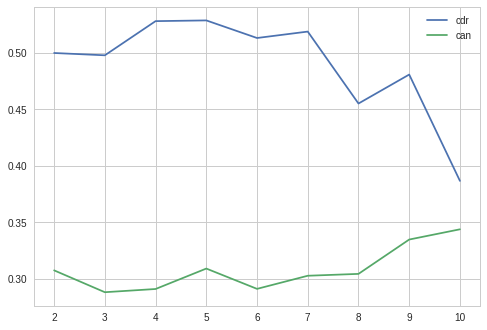

In [5]:
from collections import Counter

colors = ["red", "dodgerblue", "springgreen", "orange", "magenta", "black", "maroon", "aqua", "gold"]

def compute_sill(X, min_clusters, max_clusters, label):
    arr = []
    for n_clusters in range(min_clusters, max_clusters+1):
        clust = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, n_init=100)
        clust.fit(X)
        pred = clust.predict(X)
        arr.append(silhouette_score(X, pred))
    plt.plot(range(min_clusters, max_clusters+1), arr, label=label)
    plt.legend()
    
def clust_and_plot(X, n_clusters, sill=True):
    clust = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, n_init=100)
    clust.fit(X)
    pred = clust.predict(X)
    
    print(Counter(pred))

    fig, ax = plt.subplots(1,3,figsize=(16,5))
    ax[0].set_title("X")
    ax[1].set_title("Y")
    ax[2].set_title("Z")

    permut = np.random.permutation(range(X.shape[0]))
    pred = pred[permut]
    
    for i, row in enumerate(X[permut]):
        ax[0].plot(range(MAX_POS+1), row[range(0, MAX_POS+1)], c=colors[pred[i]], alpha=.5)
        ax[1].plot(range(MAX_POS+1), row[range(MAX_POS+1, 2*MAX_POS+2)], c=colors[pred[i]], alpha=.5)
        ax[2].plot(range(MAX_POS+1), row[range(2*MAX_POS+2, 3*MAX_POS+3)], c=colors[pred[i]], alpha=.5)
        if i > 1000:
            break
            
    return clust.cluster_centers_,  \
           np.array([np.std(c - X, 0) for c in clust.cluster_centers_]), \
           pred


compute_sill(arr_cdr_coord, 2, 10, "cdr")
compute_sill(arr_can_coord, 2, 10, "can")
# compute_sill(arr_put_coord, 2, 10, "put")